# Emotion Detection

### **Importing Libraries**

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

2024-06-01 12:45:53.019715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 12:45:53.019822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 12:45:53.110334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version: 2.15.0


### **Exploring Dataset**

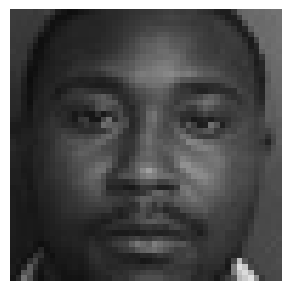

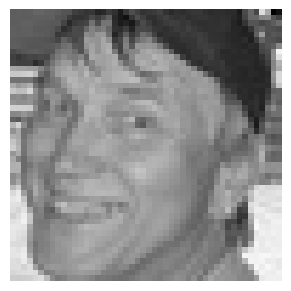

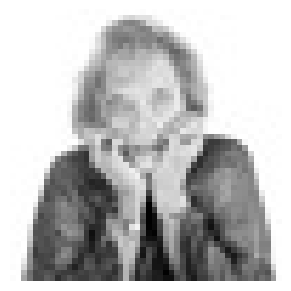

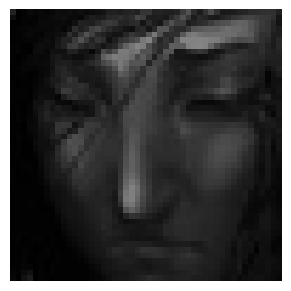

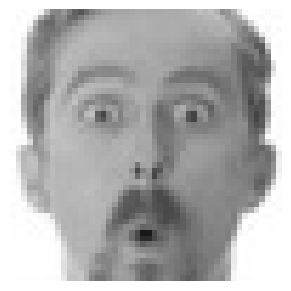

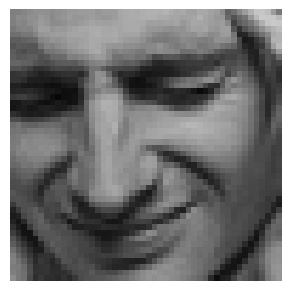

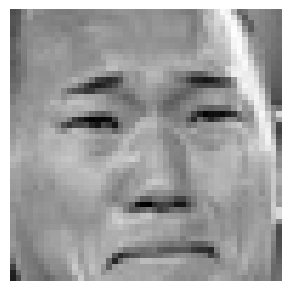

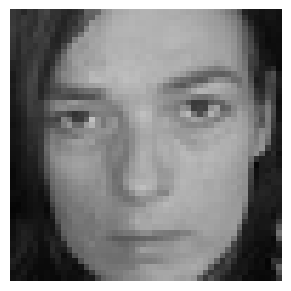

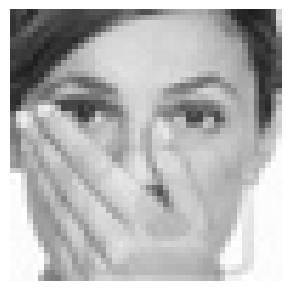

In [2]:
images = glob("/kaggle/input/fer2013/train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize = (12,12))
    plt.subplot(331 + i)
    plt.imshow(cv2.imread(image));plt.axis('off')

### **Preparing Data for Training**

In [3]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/train/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/test/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### **Defining Model**

In [4]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [5]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [6]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))
    conv_4 = Convolution(conv_3, 512, (3, 3))

    flatten = Flatten()(conv_4)
    
    dense_1 = Dense_f(flatten,256)
    dense_2 = Dense_f(dense_1, 512)

    output  = Dense(7, activation="softmax")(dense_2)
    model  =  Model(inputs=[inputs],outputs = [output])
    
    opt = Adam(learning_rate = 0.0005)
    
    model.compile(loss=['categorical_crossentropy'] , optimizer = opt , metrics =["accuracy"])

    return model

In [7]:
model = model_fer((48, 48, 1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,90

 Total params: 2,036,871 (7.77 MB)

 Trainable params: 2,033,863 (7.76 MB)

 Non-trainable params: 3,008 (11.75 KB)

### **Initializing the Model**

In [8]:
epochs = 15

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

checkpoint = ModelCheckpoint("model.weights.h5", monitor = 'val_accuracy', save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 2, min_lr = 0.00001)
callbacks = [checkpoint,reduce_lr]

# Traning the Model

In [9]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:29:50 20s/step - accuracy: 0.2031 - loss: 2.1277

I0000 00:00:1717246039.819813     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717246039.845199     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/448 ━━━━━━━━━━━━━━━━━━━━ 1:34 329ms/step - accuracy: 0.2068 - loss: 2.0815

W0000 00:00:1717246092.149592     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


446/448 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.2375 - loss: 1.9761

W0000 00:00:1717246154.512423     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 164s 322ms/step - accuracy: 0.2378 - loss: 1.9753 - val_accuracy: 0.3189 - val_loss: 1.9067 - learning_rate: 5.0000e-04
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3438 - loss: 1.7850

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3438 - loss: 1.7850 - val_accuracy: 0.3000 - val_loss: 1.9319 - learning_rate: 5.0000e-04
Epoch 3/15


W0000 00:00:1717246184.819704     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3702 - loss: 1.6412
Epoch 3: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.3703 - loss: 1.6409 - val_accuracy: 0.4122 - val_loss: 1.4893 - learning_rate: 5.0000e-04
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3594 - loss: 1.6325
Epoch 4: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step - accuracy: 0.3594 - loss: 1.6325 - val_accuracy: 0.3000 - val_loss: 1.6277 - learning_rate: 5.0000e-04
Epoch 5/15
446/448 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4293 - loss: 1.4812
Epoch 5: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.4294 - loss: 1.4810 - val_accuracy: 0.4643 - val_loss: 1.3804 - learning_rate: 5.0000e-04
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4531 - loss: 1.3513
Epoch 6: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - accuracy:

### **Model Evaluation**

In [10]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.5659 - loss: 1.1252


[1.1335891485214233, 0.5656171441078186]

### **Plotting Loss**

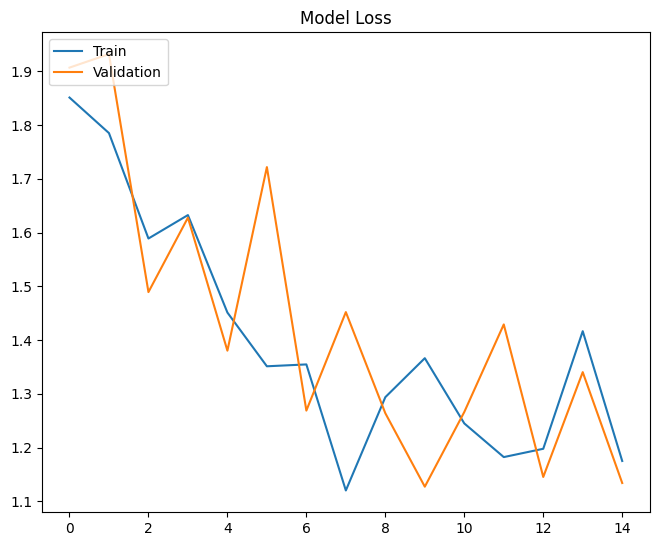

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

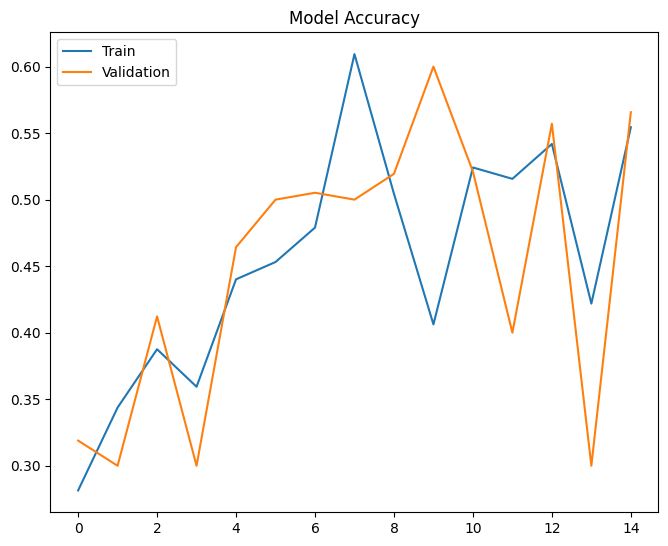

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train','Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right =0.95,left=0.0,hspace=0.25,wspace=0.35)

### **Saving Model**

In [14]:
model_json = model.to_json()
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.weights.h5")